# WhatsApp Group Chat Analysis

I have imported a group chat from my class group ( excluding stickers, images and videos) and used my analytic skills to find interesting things like whose most active from our group, most active days and hours, most used words, emojis used, number of media messages, URLs sent etc.
hop you will find this interesting because you can use it in your own groups too :)

Firstly, let's import all the necessary libraries

In [120]:
import regex
import re
import pandas as pd
import numpy as np
import seaborn as sns
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import fileinput
import nltk



Now, let's define some functions which would recognise the date, time, author and the message from the data imported.

I'm using regular expressions to find out these with the help of regex library

### DATA PREPROCESSING

In [121]:
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = regex.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

In [122]:
data = []
conversation = 'Chem_Fam_Whatsapp_chat.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

Let's create a pandas data frame with four columns as mentioned below which are the basic of any chat.

In [124]:
df = pd.DataFrame(data,columns=['Date', 'Time', 'Author', 'Message'])

Let's have a look at our data frame.

In [125]:
df

,Date,Time,Author,Message
0,15/04/2020,12:52 pm,None,Suzz was added
1,04/06/2020,2:02 pm,Akshaya CR@iitm,<Media omitted>
2,04/06/2020,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do..."
3,04/06/2020,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ..."
4,04/06/2020,2:23 pm,Abhilash Ch19,🤦🏻‍♂️
...,...,...,...,...
15407,11/07/2021,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...
15408,11/07/2021,5:59 pm,Shashank Swaminathan Ch19,No
15409,11/07/2021,5:59 pm,Sundar Ram Ch19,+1
15410,11/07/2021,6:00 pm,Sridurga Ch19,+


As seen, our data contains 15412 messages in total. This data is from April, 2020 to June 2021.

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15412 entries, 0 to 15411
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     15412 non-null  object
 1   Time     15412 non-null  object
 2   Author   15048 non-null  object
 3   Message  15412 non-null  object
dtypes: object(4)
memory usage: 481.8+ KB


Finding the number of students in our class group

In [127]:
df.Author.nunique()

98

Wait, there are only 97 students in our class. Where did this 98th person come from? 

Well it is None but not a person. Messages grouped under none are something like someone are added and left etc.


In [128]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
0,15/04/2020,12:52 pm,None,Suzz was added
17,04/06/2020,2:36 pm,None,Sundar Ram Ch19: https://docs.google.com/forms...
142,04/06/2020,3:50 pm,None,Srivatsan Ch19: Sundar be like: But we had D a...
319,07/06/2020,2:10 pm,None,Vallabh Ch19 changed their phone number to a n...
321,07/06/2020,2:31 pm,None,+91 80879 47897 left


In [129]:
null_authors_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 0 to 15288
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     364 non-null    object
 1   Time     364 non-null    object
 2   Author   0 non-null      object
 3   Message  364 non-null    object
dtypes: object(4)
memory usage: 14.2+ KB


There are 364 messages with author as None.
Let's remove such messages as they are of no use.

In [130]:
df = df.drop(null_authors_df.index) 

In [131]:
total_msgs_after_dropping_none=df.shape[0]
total_msgs_after_dropping_none

15048

So now there are 15048 messages from our class students in our data.

Let's dive into the most interesting part of our project that is exploring the chats and find interesting insights.

## Exploratory Data Analysis

As we know any whatsapp group would contain links, media, emojis and normal messages.

Lets's find seperately the number of links sent, messages containing media and emojis.

### URLs in messages

Let's introduce a new column containing number of URLs in the message.

I'm using regex again to find the links in the messages.

In [132]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
df

,Date,Time,Author,Message,urlcount
1,04/06/2020,2:02 pm,Akshaya CR@iitm,<Media omitted>,0
2,04/06/2020,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do...",0
3,04/06/2020,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ...",0
4,04/06/2020,2:23 pm,Abhilash Ch19,🤦🏻‍♂️,0
5,04/06/2020,2:31 pm,Akshaya CR@iitm,<Media omitted>,0
...,...,...,...,...,...
15407,11/07/2021,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...,0
15408,11/07/2021,5:59 pm,Shashank Swaminathan Ch19,No,0
15409,11/07/2021,5:59 pm,Sundar Ram Ch19,+1,0
15410,11/07/2021,6:00 pm,Sridurga Ch19,+,0


Let's see how many links are sent in the group.

In [133]:
links = np.sum(df.urlcount)
links

207

Well, there are 207 links.

Now, let's have a glance on the emojis used.

## Emojis in messages

I'm defining a function to extract emojis which uses emoji library in python.

In [134]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])
df['emoji']=df["Message"].apply(extract_emojis)
emojis=sum(df['emoji'].str.len())
emojis

9203

Wow, a total of 9203 emojis are sent. This says hat many students in the group have a habbit of sending emojis along with messages.

Let's find the most used emojis in the group

In [135]:
total_emojis_list = list([a for b in df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(10)

,emoji,count
0,🥳,2197
1,😂,1858
2,👍,997
3,🏻,420
4,🎉,407
5,🔥,389
6,🎂,197
7,✌,190
8,🎊,156
9,🏼,140


Partying face is used most. This is mostly used during wishing someone may be on thier birthday or during any happy event. Let's find the reason for using this emoji in the later sections.

Let's visualize the usage of emojis with a tree map

In [137]:
import plotly.express as px
fig = px.treemap(emoji_df, path= ['emoji'],
    values = emoji_df['count'].tolist(),
)
fig.show()

Now, let's look into the media sent in the chats.

### Media in messages

As I have excluded media in the data imported, the message will be in the form <Media omitted>.

Let's extract such messages as a seperate data frame for further analysis.

In [138]:
media_messages_df = df[df['Message'] == '<Media omitted>']
print(media_messages_df.head())

           Date     Time           Author          Message  urlcount emoji
1    04/06/2020  2:02 pm  Akshaya CR@iitm  <Media omitted>         0      
5    04/06/2020  2:31 pm  Akshaya CR@iitm  <Media omitted>         0      
33   04/06/2020  2:41 pm  Akshaya CR@iitm  <Media omitted>         0      
53   04/06/2020  2:52 pm   Hammem Ridhwan  <Media omitted>         0      
101  04/06/2020  3:35 pm  Prathamesh Ch19  <Media omitted>         0      


In [139]:
media_messages=media_messages_df.shape[0]
media_messages

1115

There are 1115 messages containing media in the data.

Now let's find the senders of these media messages.

<AxesSubplot:>

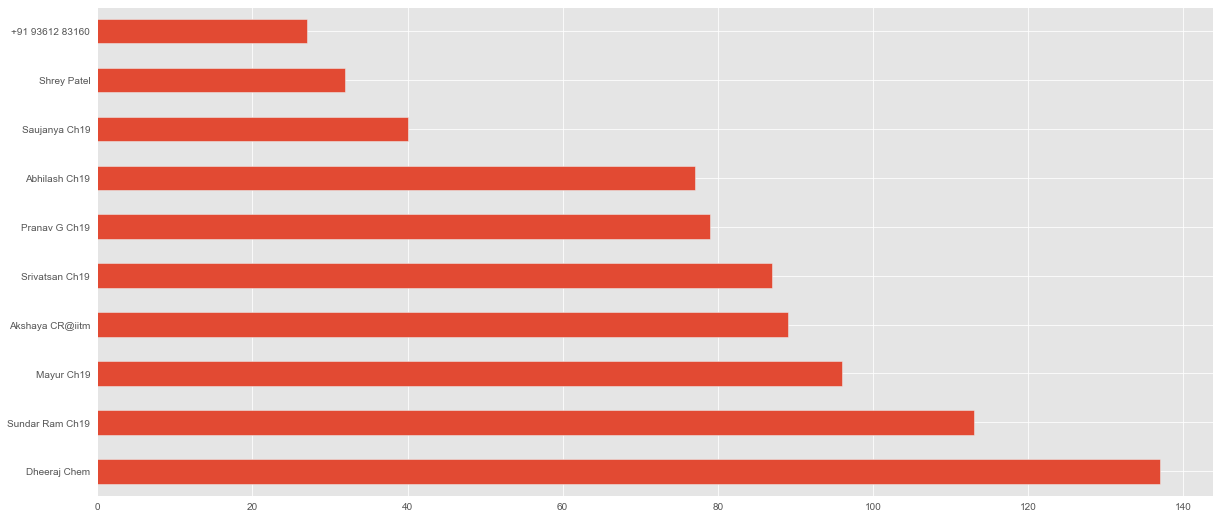

In [140]:
author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts.plot.barh()

As we have come across the various types of messages sent, let's have a summary of the chats in the group.

In [141]:
print("Summary of Chats in the group")
print("Total Messages: ", total_msgs_after_dropping_none)
print("Number of Media Shared: ", media_messages)
print("Number of Emojis Shared:", emojis)
print("Number of Links Shared", links)

Summary of Chats in the group
Total Messages:  15048
Number of Media Shared:  1115
Number of Emojis Shared: 9203
Number of Links Shared 207


Now, Let's find the number of messages sent by each one in the group.

In [142]:
# Createing a list of unique Authors
l = df.Author.unique()
for i in range(len(l)):
  # Filtering out messages of particular user
  req_df = df[df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

Akshaya CR@iitm   ->   718
Srivatsan Ch19   ->   1007
Abhilash Ch19   ->   1075
Dheeraj Chem   ->   1481
Sundar Ram Ch19   ->   2556
Srikar Chem   ->   183
+91 79907 79879   ->   77
+91 90821 10136   ->   26
Krishnashish Das   ->   79
Aditya Kale   ->   132
Neha Anand Ch 19   ->   100
Pranav G Ch19   ->   677
Soumya Verma Ch19   ->   82
Mihir Ch19   ->   48
Vallabh Ch19   ->   78
Karthik 11 @iitm   ->   10
Hammem Ridhwan   ->   62
Prathamesh Ch19   ->   110
Ajay Chem   ->   41
Srinivas Chem@iitm   ->   8
+91 97816 62850   ->   20
+91 94888 55235   ->   5
+91 83300 39077   ->   79
Kush Ch19   ->   414
Asritha Chem   ->   74
Jahnavi Chem   ->   75
Jai Ch19   ->   70
Koushik Chem   ->   3
Swathi Chem   ->   346
Sahil Ch19   ->   71
Saujanya Ch19   ->   376
Deepak Ch19   ->   69
+91 6204 814 826   ->   12
+91 75708 72142   ->   70
Mayur Ch19   ->   486
+91 6239 658 379   ->   59
Alok Krishna Ch19   ->   265
Prateek Ch19   ->   166
Shrey Patel   ->   580
+91 92655 17913   ->   50
Avinash Lp

Wow, we have students who have sent more than 1000 messages and those who have sent only 1 message. As expected any class of students would have introverts and hyper active ones.

Now, Let's look who are the most active ones in the group

<AxesSubplot:>

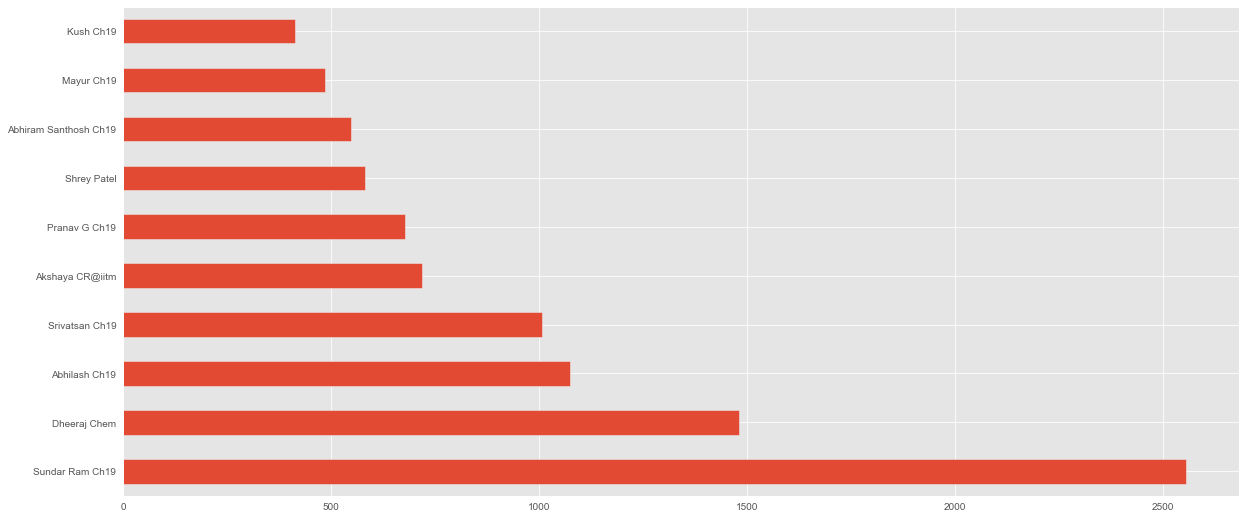

In [151]:
author_value_counts = df['Author'].value_counts() 
top_10_author_value_counts = author_value_counts.head(10) 
top_10_author_value_counts.plot.barh()


We got an intersting thing here. The user who have sent the highest number of media messages is not the one who have sent highest number of messages. Also we can see a clear dominance of a single person in the group.

Let's create a seperate dataframe of these most active users to do further analysis and visualization.

In [150]:
whatsapp_df1 = df.copy()
whatsapp_df1['Number_of_messages'] = [1]* whatsapp_df1.shape[0]
whatsapp_df1 = whatsapp_df1.groupby('Author')['Number_of_messages'].count().sort_values(ascending = False).reset_index() 
whatsapp_df2=whatsapp_df1.head(10)
whatsapp_df2

,Author,Number_of_messages
0,Sundar Ram Ch19,2556
1,Dheeraj Chem,1481
2,Abhilash Ch19,1075
3,Srivatsan Ch19,1007
4,Akshaya CR@iitm,718
5,Pranav G Ch19,677
6,Shrey Patel,580
7,Abhiram Santhosh Ch19,548
8,Mayur Ch19,486
9,Kush Ch19,414


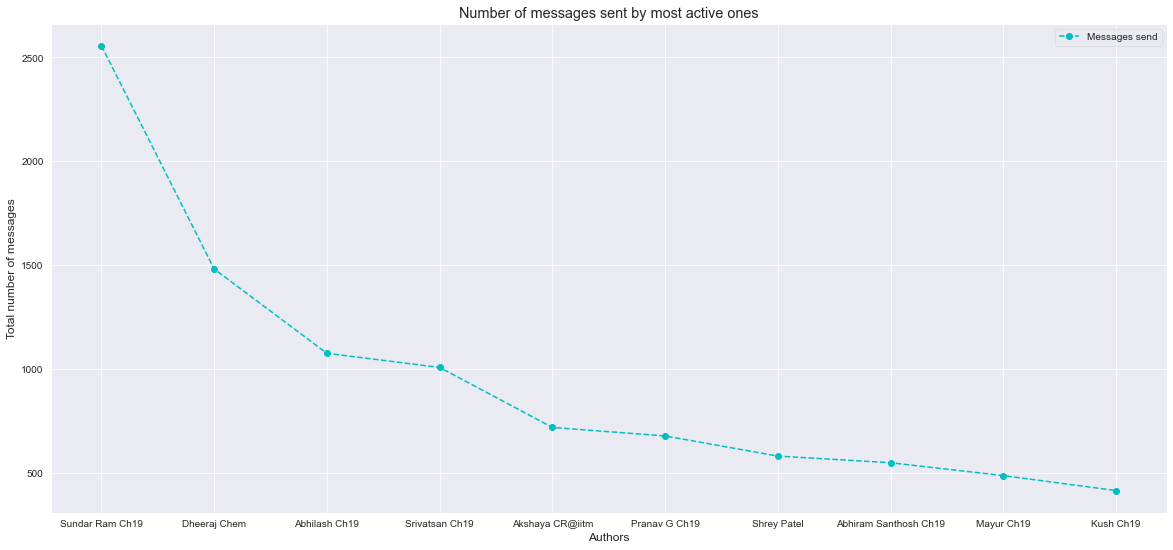

In [147]:
#  Using seaborn for Styles 
sns.set_style("darkgrid")

# Resize the  figure size
plt.figure(figsize=(20, 9))

# Here we are ploting the line chart using plt.plot 
plt.plot(whatsapp_df2.Author, whatsapp_df2.Number_of_messages, 'o--c')  

# In here we are writing the Labels and Title for the plot chart
plt.xlabel('Authors')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by most active ones")
plt.legend(['Messages send']);

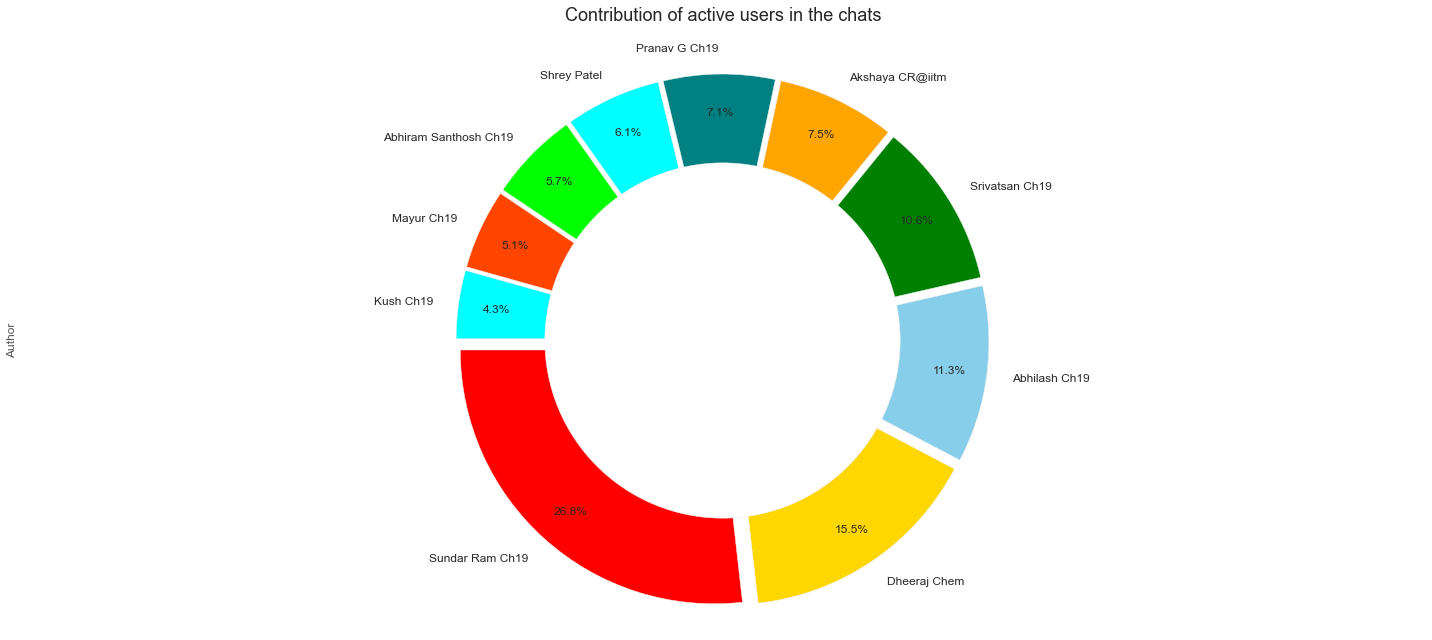

In [148]:
plt.style.use('ggplot')

user=df.groupby('Author')['Author'].count().nlargest(10)

def user_chat_pie(user):
    fig, ax = plt.subplots()
    explodex = []
    for i in np.arange(len(user)):
        explodex.append(0.05)
    ax = user.plot(kind='pie', colors = ['red','gold','skyblue','green','orange','teal','cyan','lime','orangered','aqua'], fontsize=12, autopct='%1.1f%%', startangle=180, pctdistance=0.85, explode = explodex)
    inner_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(inner_circle)
    ax.axis('equal')  
    ax.set_title("Contribution of active users in the chats\n", fontsize=18)
    plt.tight_layout()
    plt.show()
user_chat_pie(user)

Now, let's have a look into the introverts in the class.

<AxesSubplot:>

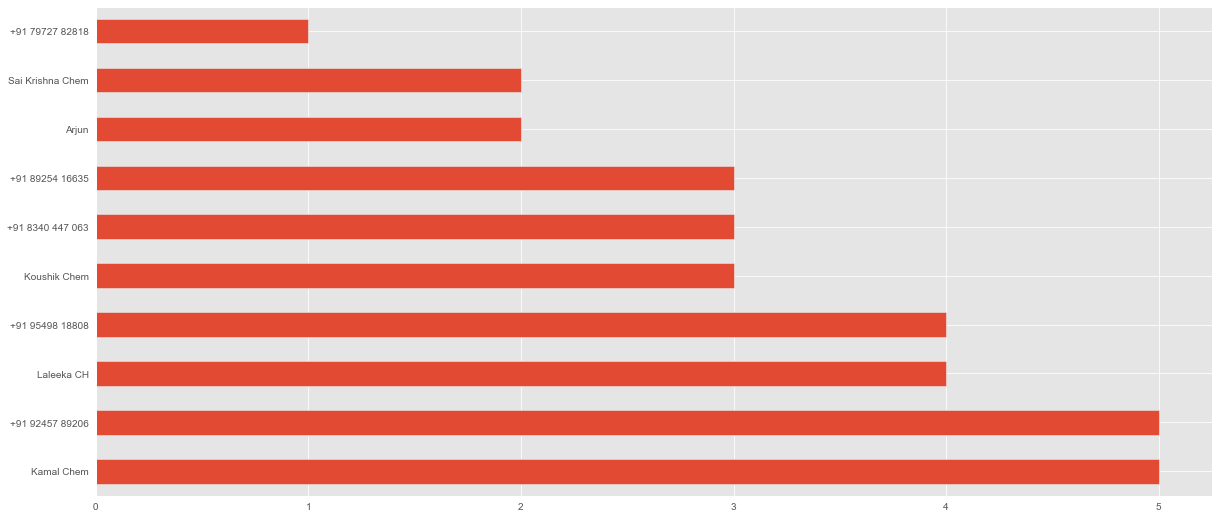

In [152]:
Least_10_author_value_counts = author_value_counts.tail(10) 
Least_10_author_value_counts.plot.barh()

### Number of Letters and Words in messages

Let's introduce two columns Letter-count and Word_count into our data which counts the letters and words present in each message.

In [153]:
df['Letter_Count'] = df['Message'].apply(lambda s : len(s))
df['Word_Count'] = df['Message'].apply(lambda s : len(s.split(' ')))
df

,Date,Time,Author,Message,urlcount,emoji,Letter_Count,Word_Count
1,04/06/2020,2:02 pm,Akshaya CR@iitm,<Media omitted>,0,,15,2
2,04/06/2020,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do...",0,🥺,84,12
3,04/06/2020,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ...",0,🤦♀,97,19
4,04/06/2020,2:23 pm,Abhilash Ch19,🤦🏻‍♂️,0,🤦🏻♂,5,1
5,04/06/2020,2:31 pm,Akshaya CR@iitm,<Media omitted>,0,,15,2
...,...,...,...,...,...,...,...,...
15407,11/07/2021,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...,0,,56,13
15408,11/07/2021,5:59 pm,Shashank Swaminathan Ch19,No,0,,2,1
15409,11/07/2021,5:59 pm,Sundar Ram Ch19,+1,0,,2,1
15410,11/07/2021,6:00 pm,Sridurga Ch19,+,0,,1,1


Let's find the aveerage number of letters and words per message.

In [156]:
average_message_words = df['Word_Count'].mean()
average_message_letters = df['Letter_Count'].mean()
average_message_day = df.groupby('Date')['Message'].count().mean()

In [157]:
print('Average Words per Message', round(average_message_words, 2))
print('Average Letters per Message', round(average_message_letters, 2))
print('Average Message Per Day', round(average_message_day, 2))

Average Words per Message 7.02
Average Letters per Message 38.73
Average Message Per Day 47.77


Finding total number of letters and words in the entire data

In [158]:
print("total number of words are :", df.Word_Count.sum())
print("total number of letters are :", df.Letter_Count.sum())

total number of words are : 105616
total number of letters are : 582790


Now, let's find the statistics of each student in the group like number of messages sent, URLs,media and emojis in those messages.

In [159]:
l = df.Author.unique()
for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= df[df["Author"] == l[i]]
  print(f'Stats of {l[i]} -')
  # Printing number of messages sent
  print('Messages Sent', req_df.shape[0])
  # Number of words per each message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Average Words per message', words_per_message)
  # Number of messsages containing media
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # Number of messages containing emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  # Number of messages containing links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)
  print()

Stats of Akshaya CR@iitm -
Messages Sent 718
Average Words per message 15.321727019498606
Media Messages Sent 89
Emojis Sent 362
Links Sent 33

Stats of Srivatsan Ch19 -
Messages Sent 1007
Average Words per message 10.023833167825224
Media Messages Sent 87
Emojis Sent 409
Links Sent 36

Stats of Abhilash Ch19 -
Messages Sent 1075
Average Words per message 6.067906976744186
Media Messages Sent 77
Emojis Sent 593
Links Sent 25

Stats of Dheeraj Chem -
Messages Sent 1481
Average Words per message 7.340310600945307
Media Messages Sent 137
Emojis Sent 167
Links Sent 4

Stats of Sundar Ram Ch19 -
Messages Sent 2556
Average Words per message 6.989827856025039
Media Messages Sent 113
Emojis Sent 722
Links Sent 1

Stats of Srikar Chem -
Messages Sent 183
Average Words per message 4.683060109289618
Media Messages Sent 18
Emojis Sent 164
Links Sent 3

Stats of +91 79907 79879 -
Messages Sent 77
Average Words per message 2.5584415584415585
Media Messages Sent 0
Emojis Sent 150
Links Sent 0

Stats 

From the statistics above, details of any students in the group can be found.
Now let's start analysing the words and letters sent. For this we can drop the media messages as this message is stated as media ommitted and we have no use of this anymore.

In [160]:
images = df[df['Message'] == "<Media omitted>"]
df.drop(images.index, inplace=True)


In [161]:
df

,Date,Time,Author,Message,urlcount,emoji,Letter_Count,Word_Count
2,04/06/2020,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do...",0,🥺,84,12
3,04/06/2020,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ...",0,🤦♀,97,19
4,04/06/2020,2:23 pm,Abhilash Ch19,🤦🏻‍♂️,0,🤦🏻♂,5,1
6,04/06/2020,2:32 pm,Akshaya CR@iitm,Fill it up peeps🙃🙃,0,🙃🙃,18,4
7,04/06/2020,2:32 pm,Dheeraj Chem,Why don't we take a head count here itself?,0,,43,9
...,...,...,...,...,...,...,...,...
15407,11/07/2021,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...,0,,56,13
15408,11/07/2021,5:59 pm,Shashank Swaminathan Ch19,No,0,,2,1
15409,11/07/2021,5:59 pm,Sundar Ram Ch19,+1,0,,2,1
15410,11/07/2021,6:00 pm,Sridurga Ch19,+,0,,1,1


Now let's find who is the most messages sender without media

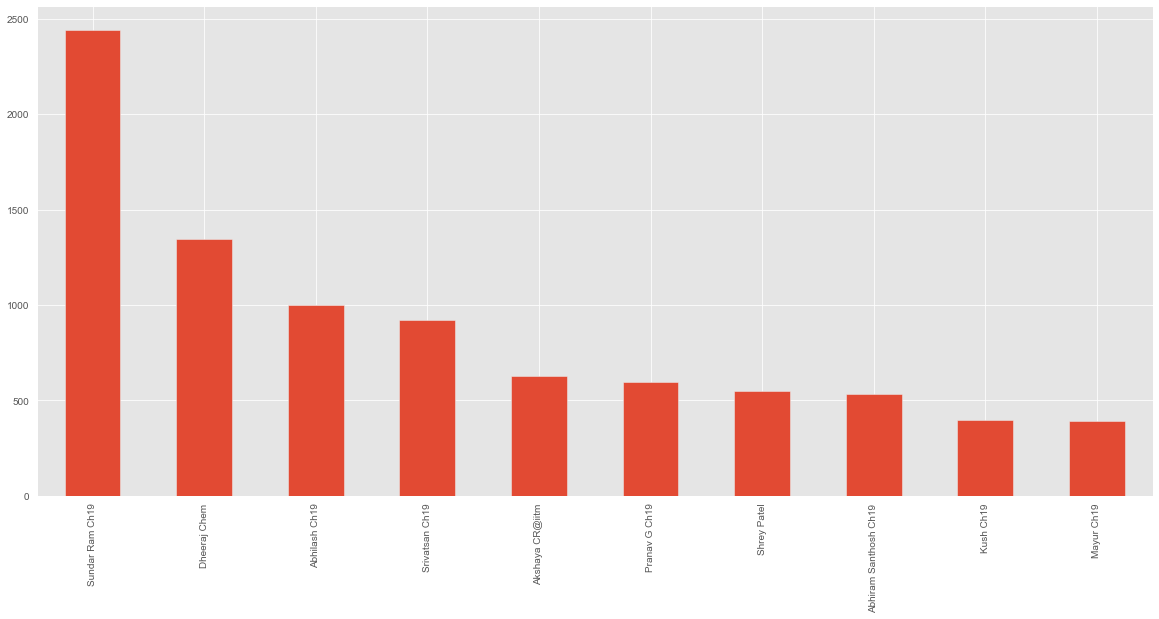

In [163]:
author_value_counts = df['Author'].value_counts() 
top_10_author_value_counts = author_value_counts.head(10) 
top_10_author_value_counts.plot.bar();

Still, the same guy is dominating by a great margin.

Now, let's find who has sent most number of words.

Text(0, 0.5, 'Authors')

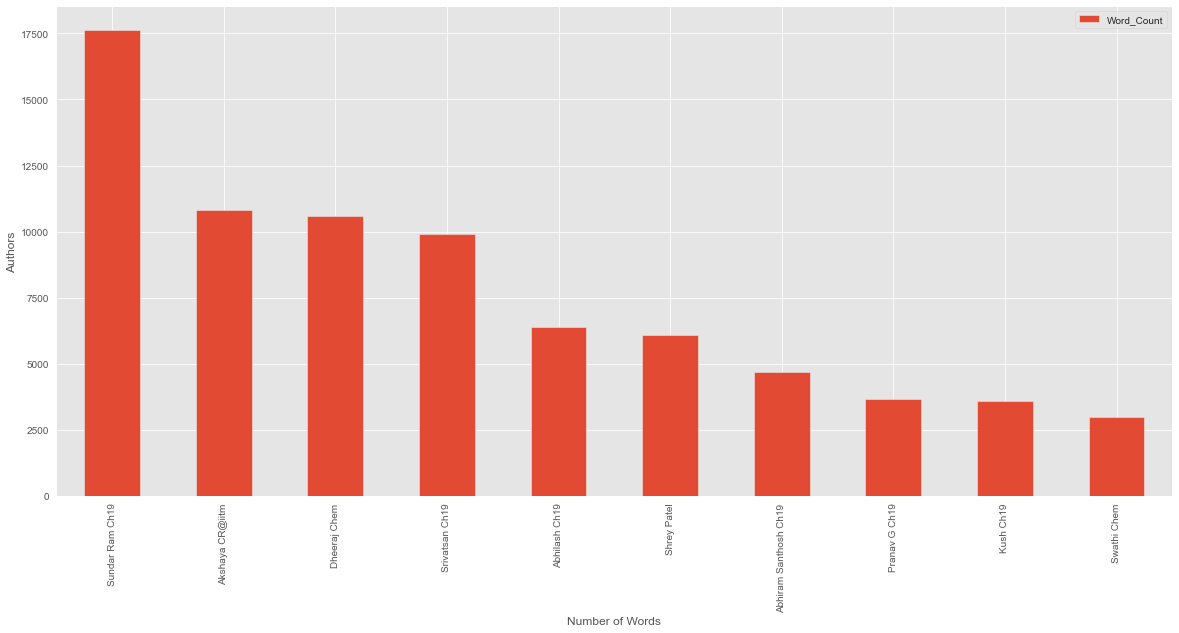

In [168]:
total_word_count_grouped_by_author = df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.bar()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

Wait, we found a student coming up to third position under word count form 5th position in the messages count. This tells that she has sent really long messages.

Defining a function to visualize this in the form of a pie chart

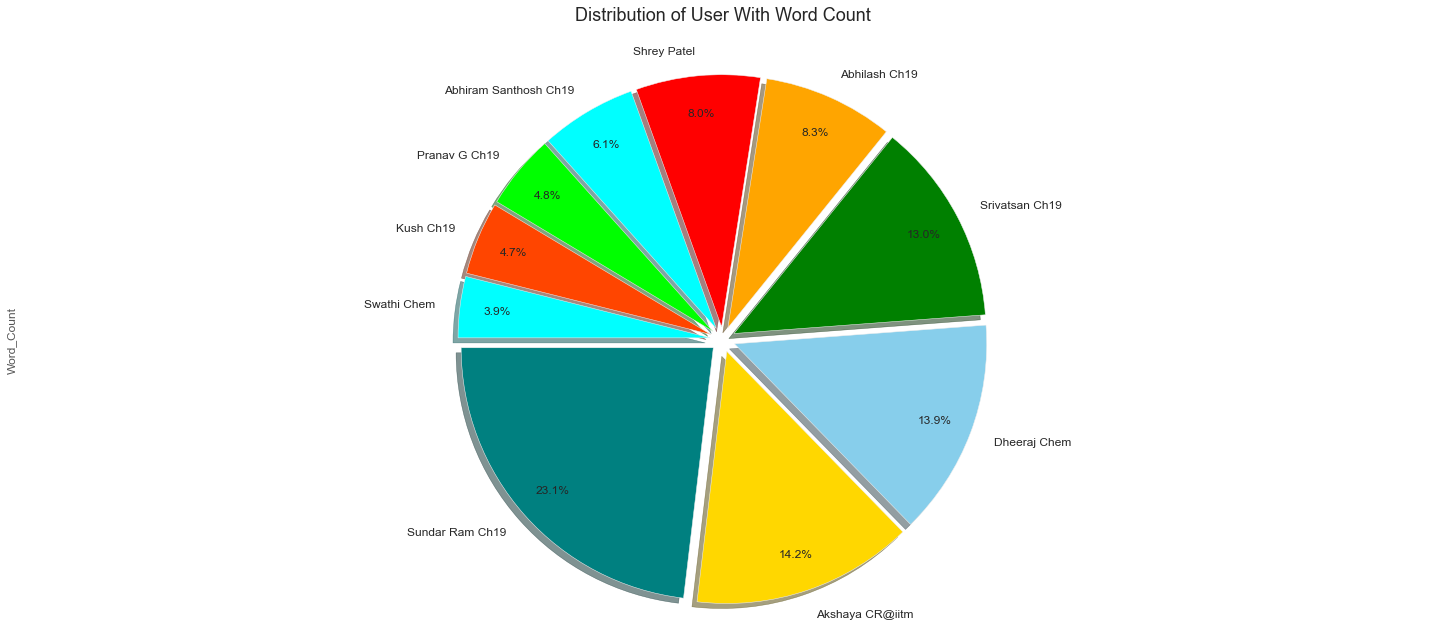

In [170]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

word_count=df.groupby(['Author'])['Word_Count'].sum().nlargest(10)

def pie_chart(word_count):
    fig, ax = plt.subplots()
    explodex = []
    for i in np.arange(len(word_count)):
        explodex.append(0.05)
    ax = word_count.plot(kind='pie', colors = ['teal','gold','skyblue','green','orange','red','cyan','lime','orangered','aqua'],shadow=True, fontsize=12, autopct='%1.1f%%', startangle=180, pctdistance=0.85, explode = explodex)
    ax.axis('equal')  
    ax.set_title("Distribution of User With Word Count\n", fontsize=18)
    plt.tight_layout()
    plt.show()

pie_chart(word_count)

Now, lets sort the messages according to number of words in them

Text(0, 0.5, 'Frequency')

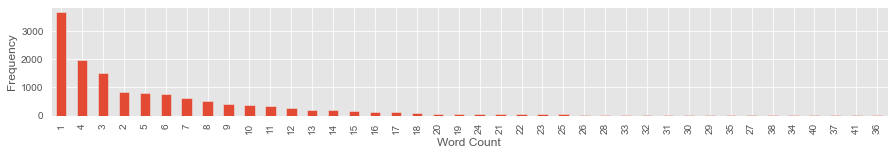

In [172]:

plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts =df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Well, we have most numbers of messages with single word. These could be the messages of acknowledgement to any important message sent by Class representative mostly.

Now, let's find the message with highest number of words, date and the author of that message

In [173]:
df.iloc[df['Word_Count'].argmax()]

Date                                                   21/08/2020
Time                                                     11:05 pm
Author                                            Sundar Ram Ch19
Message         Project Group 1\tch19b063 Kush Ganatra, ch19b0...
urlcount                                                        0
emoji                                                            
Letter_Count                                                 2984
Word_Count                                                    383
Name: 2644, dtype: object

Wow, we can see a message containing 383 words in it. We can see that there are messages with words greater than 300 and with a single word which is general in any group.

Now, coming to the letter count. 

Finding the authors who have typed most number of letters.

Text(0, 0.5, 'Authors')

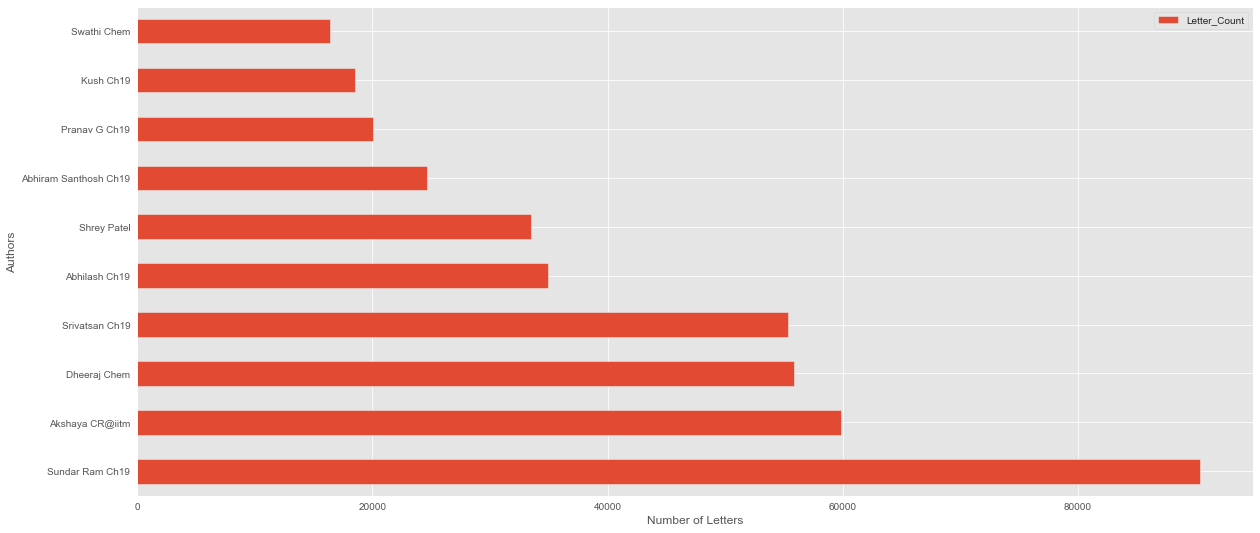

In [174]:

total_letter_count_grouped_by_author = df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_grouped_by_author = total_letter_count_grouped_by_author.sort_values('Letter_Count', ascending=False)
top_10_sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_grouped_by_author.head(10)
top_10_sorted_total_letter_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Letters')
plt.ylabel('Authors')

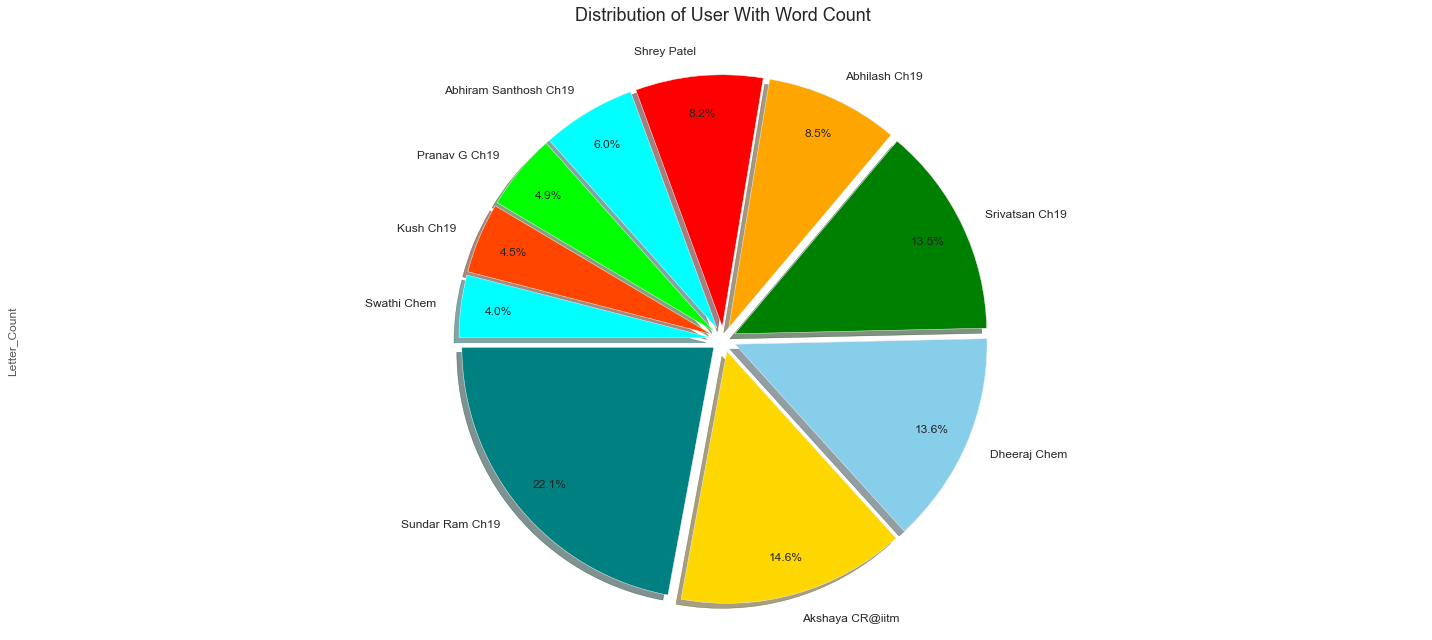

In [175]:
plt.style.use('ggplot')

Letter_count=df.groupby(['Author'])['Letter_Count'].sum().nlargest(10)
# Using the function defined earlier
pie_chart(Letter_count)


Now, Let'sort the messages according to the number of letters in it.

Text(0, 0.5, 'Frequency')

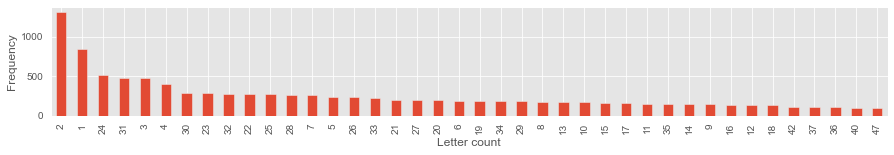

In [176]:

plt.figure(figsize=(15, 2))
letter_count_value_counts = df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

Again, most of the messages contains very few letters which is in accordance with the number of words in most of the messages.

It's time to bring in Natural Language Processing into action. 

We will find the most used word in the group and then create a word cloud. 

In [177]:
from nltk.stem import WordNetLemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer

In [178]:

from nltk.corpus import stopwords
messages = []
stop_words = set(stopwords.words('english'))

for words in df['Message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenizing the sentences
    lower_case = [l.lower() for l in tokens] #converting all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Removing stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizing the words i.e converting similar words to their
    # base form while still considering the context in which the words are used 

    messages.append(' '.join(lemmas)) 

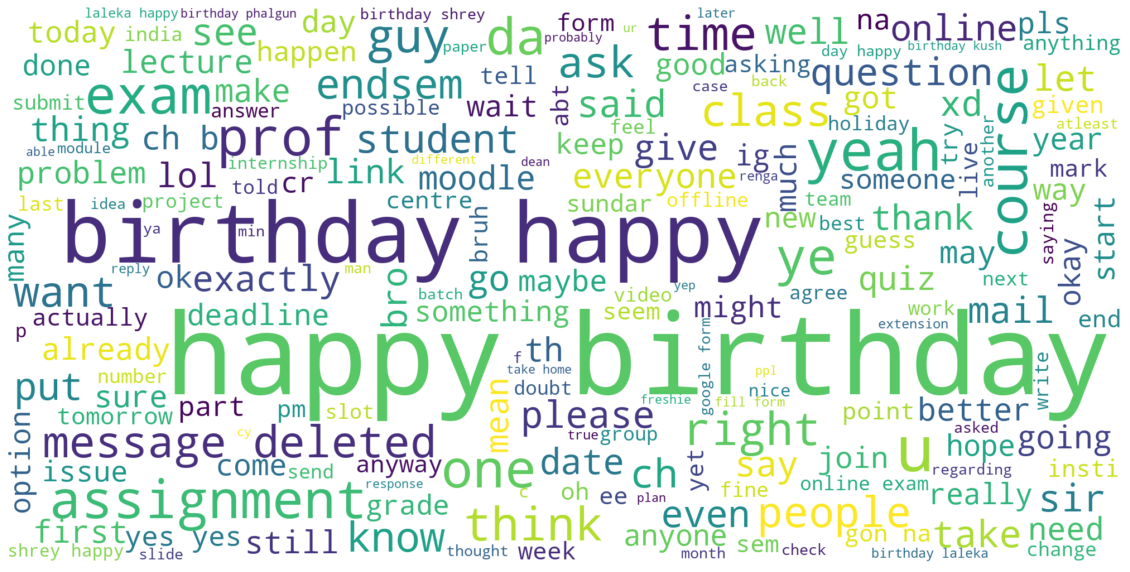

In [179]:
# Using worldcloud to visualize the messages
unique_string=(" ").join(messages)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The above visualization shows that this class's WhatsApp group chat is a friendly group with lots of birthday wishes .

As this contains many words, let's visualize the most important terms using CountVectorizer

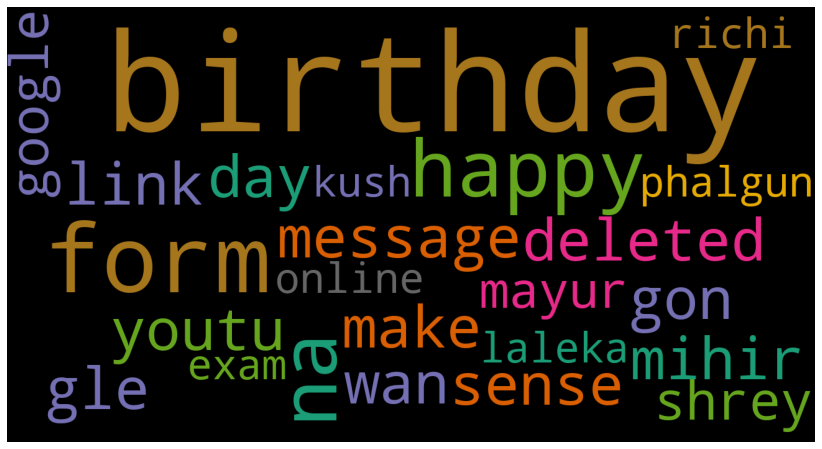

In [180]:
cv = CountVectorizer(analyzer = "word",stop_words = 'english',max_features = 20,ngram_range=(2,2))
important_words = cv.fit_transform(messages)
fig_words = cv.vocabulary_

unique_data=(" ").join(fig_words)
wordcloud = WordCloud(width = 1300, height = 700,colormap="Dark2").generate(unique_data)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

In [181]:
co = CountVectorizer(ngram_range=(2,2),stop_words='english')
counts = co.fit_transform(messages)
pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)

,0
happy birthday,1740
message deleted,200
gon na,64
online exam,57
http youtu,53
birthday shrey,49
google form,45
birthday laleka,45
birthday phalgun,43
birthday kush,42


As seen, most of the messages were related to birthday wishes. This is the reason for using the partying face emoji more as found earlier.

Moving to the next part i.e analyzing these chats with the info of date and time we have.

## DATE, TIME, MONTH, DAY, YEAR

Now let us analyse these chats based on the date and time they were sent

Lets create two columns containing the month and year of sent messages from the date column

In [209]:
df['Date'] = pd.to_datetime(df['Date'])


# Getting Month from Date
df['Month']=df['Date'].dt.month

df

,Date,Time,Author,Message,urlcount,emoji,Letter_Count,Word_Count,Month,Hours,Day
2,2020-04-06,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do...",0,🥺,84,12,4,14,Monday
3,2020-04-06,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ...",0,🤦♀,97,19,4,14,Monday
4,2020-04-06,2:23 pm,Abhilash Ch19,🤦🏻‍♂️,0,🤦🏻♂,5,1,4,14,Monday
6,2020-04-06,2:32 pm,Akshaya CR@iitm,Fill it up peeps🙃🙃,0,🙃🙃,18,4,4,14,Monday
7,2020-04-06,2:32 pm,Dheeraj Chem,Why don't we take a head count here itself?,0,,43,9,4,14,Monday
...,...,...,...,...,...,...,...,...,...,...,...
15407,2021-11-07,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...,0,,56,13,11,17,Sunday
15408,2021-11-07,5:59 pm,Shashank Swaminathan Ch19,No,0,,2,1,11,17,Sunday
15409,2021-11-07,5:59 pm,Sundar Ram Ch19,+1,0,,2,1,11,17,Sunday
15410,2021-11-07,6:00 pm,Sridurga Ch19,+,0,,1,1,11,18,Sunday


### DATE

Let's look at the distribution of chats (number of messages) from April 2020 to June 2021

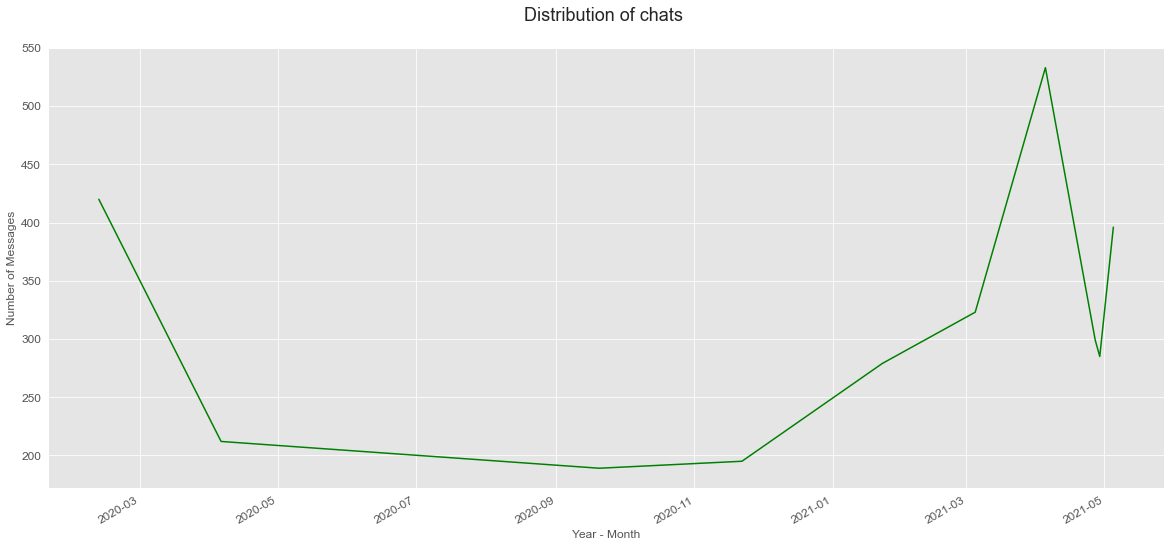

In [191]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

date=df.groupby('Date')['Date'].count().nlargest(10)
def user_line_chart(date):
    ax = date.plot(kind='line',color='green', fontsize=12)
    ax.set_title("Distribution of chats \n", fontsize=18)
    ax.set_xlabel("Year - Month", fontsize=12)
    ax.set_ylabel("Number of Messages", fontsize=12)
    plt.show()

user_line_chart(date)

The above line chart shows that messages are high in months of 2021 compared to 2020. But distribution is not much clear in some of the months as almost a horizontal line is visible. Let's go more specific by decreasing the count on Y-axis.

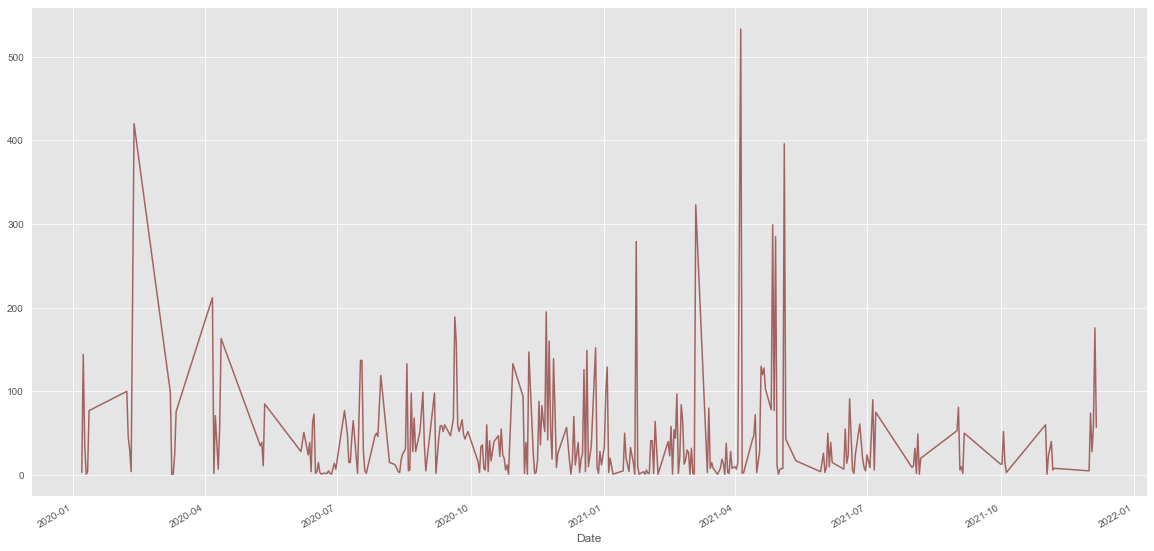

In [192]:
date_grouped = df.groupby('Date')['Message'].count().plot(kind='line', figsize=(20,10), color='#A26360')

Let's find the dates on which group was highly active

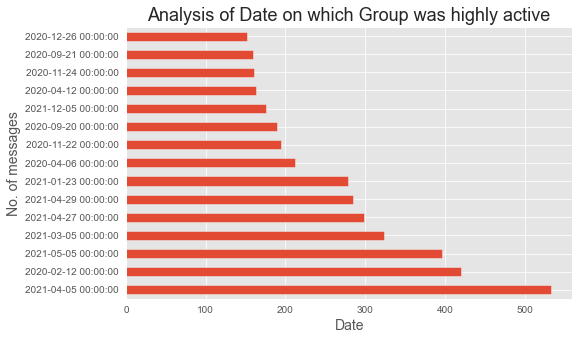

In [193]:
plt.figure(figsize=(8,5))
df['Date'].value_counts().head(15).plot.barh()
plt.xlabel('Date',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of Date on which Group was highly active',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

Wow more than 500 messages in a single day i.e on 5th April 2021. From the above bar graph we can see the top 15 days on which the group was very much active

### TIME

Now, let's find the time during which group was highly active.

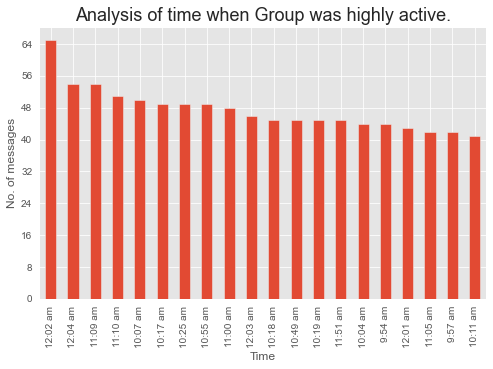

In [194]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8,5))
t = df['Time'].value_counts().head(20)
tx = t.plot.bar()
tx.yaxis.set_major_locator(MaxNLocator(integer=True))  #Converting y axis data to integer
plt.xlabel('Time',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Analysis of time when Group was highly active.',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

Most number of messages were sent exactly at 12:02 am followed by 12:04am. This is in accordance with our previous results as most common word is Happy Birthday which will be generally sent around 12 am.

Let's create a new column which contains the Hour (in 24 Hours format) during which messages was sent. This helps us to find the most active hours of the day.

In [195]:
from datetime import *

lst = []
for i in df['Time'] :
    out_time = datetime.strftime(datetime.strptime(i,"%I:%M %p"),"%H:%M")
    lst.append(out_time)
df['24H_Time'] = lst
df['Hours'] = df['24H_Time'].apply(lambda x : x.split(':')[0])
df.drop(columns="24H_Time", inplace = True)
df

,Date,Time,Author,Message,urlcount,emoji,Letter_Count,Word_Count,Year,Month,Hours
2,2020-04-06,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do...",0,🥺,84,12,2020,4,14
3,2020-04-06,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ...",0,🤦♀,97,19,2020,4,14
4,2020-04-06,2:23 pm,Abhilash Ch19,🤦🏻‍♂️,0,🤦🏻♂,5,1,2020,4,14
6,2020-04-06,2:32 pm,Akshaya CR@iitm,Fill it up peeps🙃🙃,0,🙃🙃,18,4,2020,4,14
7,2020-04-06,2:32 pm,Dheeraj Chem,Why don't we take a head count here itself?,0,,43,9,2020,4,14
...,...,...,...,...,...,...,...,...,...,...,...
15407,2021-11-07,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...,0,,56,13,2021,11,17
15408,2021-11-07,5:59 pm,Shashank Swaminathan Ch19,No,0,,2,1,2021,11,17
15409,2021-11-07,5:59 pm,Sundar Ram Ch19,+1,0,,2,1,2021,11,17
15410,2021-11-07,6:00 pm,Sridurga Ch19,+,0,,1,1,2021,11,18


Now, let's find the most suitable hour of day, whenever there will more chances of getting responce from group members.

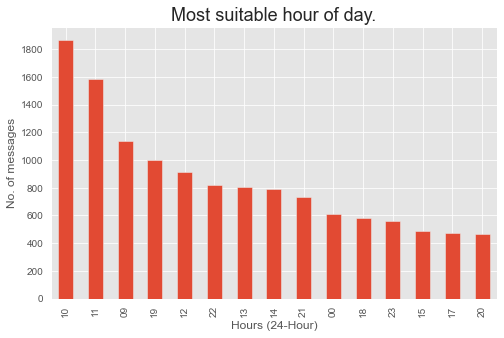

In [196]:

plt.figure(figsize=(8,5))
std_time = df['Hours'].value_counts().head(15)
s_T = std_time.plot.bar()
s_T.yaxis.set_major_locator(MaxNLocator(integer=True))  
plt.xlabel('Hours (24-Hour)',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Most suitable hour of day.',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

Surprisingly, it is not 12 am at the midnight but it is 10 am in the morning. this may be because around 12 am, people only wish but not discuss about anything in detail. So, from the bar chart it is clear that most of the discussions carry  from 9 am to 12 pm. 

Now, let's see most number of messages sent in a single hour on any day

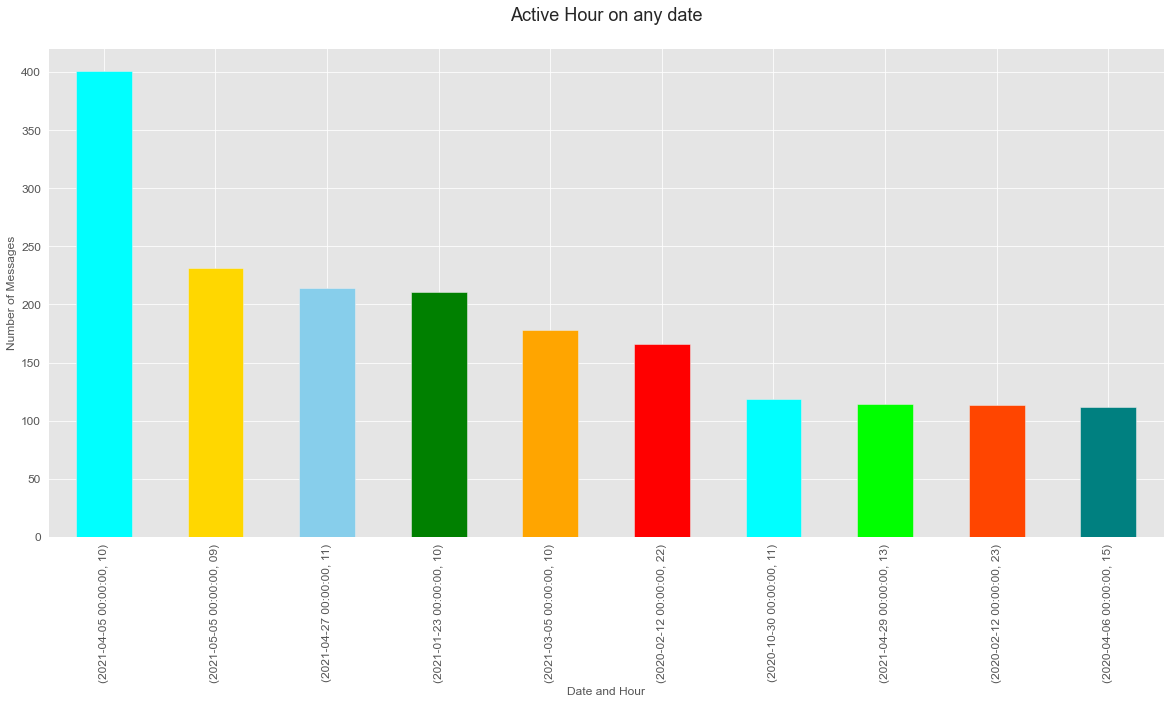

In [197]:
plt.style.use('ggplot')

active_hour=df.groupby(['Date','Hours'])['Hours'].count().nlargest(10)

def active_hours_bar_chart(active_hour):
    ax = active_hour.plot(kind='bar', color = ['aqua','gold','skyblue','green','orange','red','cyan','lime','orangered','teal'], fontsize=12)
    ax.set_title("Active Hour on any date\n", fontsize=18)
    ax.set_xlabel("Date and Hour", fontsize=12)
    ax.set_ylabel("Number of Messages", fontsize=12)
    plt.show()

active_hours_bar_chart(active_hour)

It's on 5th April,2021 which is again the day with highest messages. Also again most number of messages are sent during the morning session only. So, around 12 am, group was active only between 12 to 12:10 am during which people send the birthday wishes . 

### DAY


Now, let's find the day of week on which group members are engaged in chats.

Adding one more column of "Day" for better analysis, here we use datetime library which help us to do this task easily.

In [198]:

weeks = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thursday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}
df['Day'] = df['Date'].dt.weekday.map(weeks)

### Changing the datatype of column "Day".
df['Day'] = df['Day'].astype('category')
df

,Date,Time,Author,Message,urlcount,emoji,Letter_Count,Word_Count,Year,Month,Hours,Day
2,2020-04-06,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do...",0,🥺,84,12,2020,4,14,Monday
3,2020-04-06,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ...",0,🤦♀,97,19,2020,4,14,Monday
4,2020-04-06,2:23 pm,Abhilash Ch19,🤦🏻‍♂️,0,🤦🏻♂,5,1,2020,4,14,Monday
6,2020-04-06,2:32 pm,Akshaya CR@iitm,Fill it up peeps🙃🙃,0,🙃🙃,18,4,2020,4,14,Monday
7,2020-04-06,2:32 pm,Dheeraj Chem,Why don't we take a head count here itself?,0,,43,9,2020,4,14,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
15407,2021-11-07,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...,0,,56,13,2021,11,17,Sunday
15408,2021-11-07,5:59 pm,Shashank Swaminathan Ch19,No,0,,2,1,2021,11,17,Sunday
15409,2021-11-07,5:59 pm,Sundar Ram Ch19,+1,0,,2,1,2021,11,17,Sunday
15410,2021-11-07,6:00 pm,Sridurga Ch19,+,0,,1,1,2021,11,18,Sunday


Firstly, let's look at the total number of messages sent on each day of week 

In [199]:
l = df.Day.unique()
for i in range(len(l)):
  req_df = df[df["Day"] == l[i]]
  print(l[i],'  ->  ',req_df.shape[0])

Monday   ->   2105
Saturday   ->   1880
Thursday   ->   1578
Sunday   ->   2164
Tuesday   ->   1774
Friday   ->   2266
Wednesday   ->   2166


Let's visualize this with a bar chart 

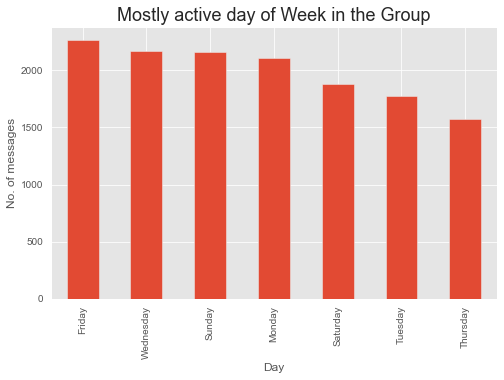

In [200]:

plt.figure(figsize=(8,5))
active_day = df['Day'].value_counts()
a_d = active_day.head(10)
a_d.plot.bar()
plt.xlabel('Day',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Mostly active day of Week in the Group',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()

Friday is the most active day of the week. Probably this is because, we usually become free on friday with minimum number of classes and relax because we do not have any academic activities on the next two days.

Let's visualize the distribution of messages among the days of week using a pie-chart so we can find percentages of total messages.

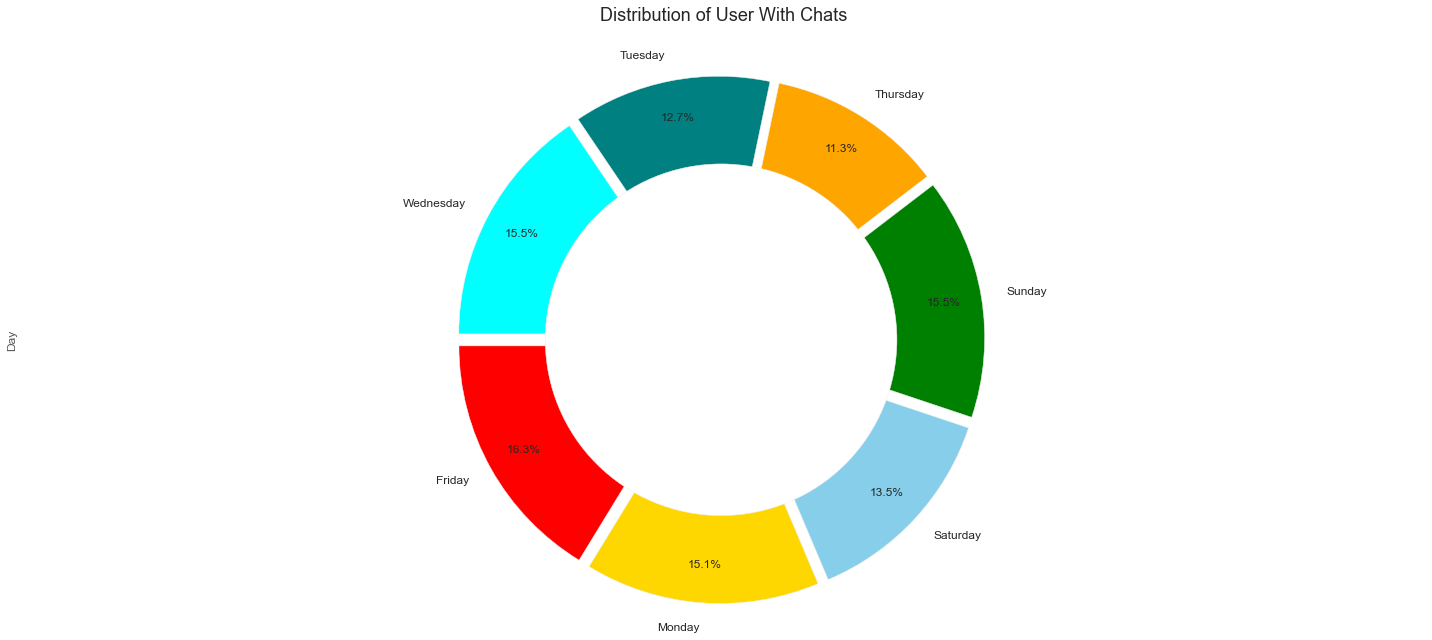

In [201]:
plt.style.use('ggplot')

user=df.groupby('Day')['Day'].count()

def user_chat_pie_day(user):
    fig, ax = plt.subplots()
    explodex = []
    for i in np.arange(len(user)):
        explodex.append(0.05)
    ax = user.plot(kind='pie', colors = ['red','gold','skyblue','green','orange','teal','cyan'], fontsize=12, autopct='%1.1f%%', startangle=180, pctdistance=0.85, explode = explodex)
    inner_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(inner_circle)
    ax.axis('equal')  
    ax.set_title("Distribution of User With Chats\n", fontsize=18)
    plt.tight_layout()
    plt.show()
user_chat_pie_day(user)

### MONTH

Now, let's find the most active month in 2021 and 2020 .

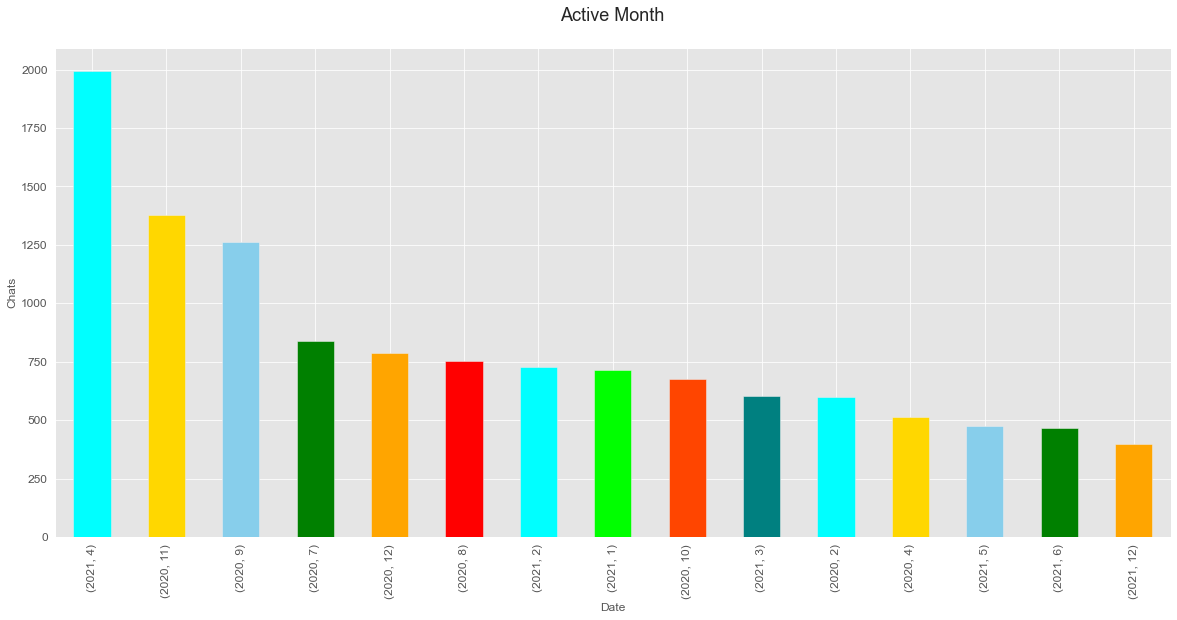

In [202]:

plt.style.use('ggplot')

active_month=df.groupby(['Year','Month'])['Month'].count().nlargest(15)

def active_month_bar_chart(active_month):
    ax = active_month.plot(kind='bar', color = ['aqua','gold','skyblue','green','orange','red','cyan','lime','orangered','teal'], fontsize=12)
    ax.set_title("Active Month\n", fontsize=18)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Chats", fontsize=12)
    plt.show()

active_month_bar_chart(active_month)

As seen, 4th month of 2021 (i.e april)is the most active month. Remember that most number of messages were also sent on 5th April 2021.

Let's substitute the names of the months for these month numbers for easy understanding.

In [203]:
df['Mon'] = df['Date'].dt.month
months = {
     1 : 'Jan',
     2 : 'Feb',
     3 : 'Mar',
     4 : 'Apr',
     5 : 'May',
     6 : 'Jun',
     7 : 'Jul',
     8 : 'Aug',
     9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec'
}
df['Month'] = df['Mon'].map(months)
df.drop('Mon',axis=1,inplace=True)

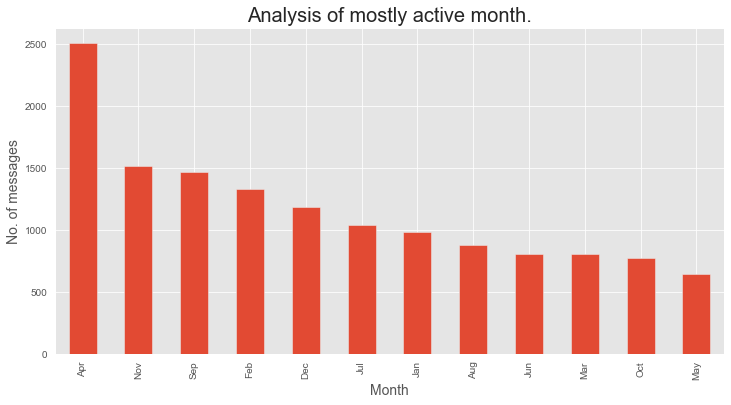

In [204]:
plt.figure(figsize=(12,6))
active_month = df['Month'].value_counts()
a_m = active_month
a_m.plot.bar()
plt.xlabel('Month',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of mostly active month.',fontdict={'fontsize': 20,
        'fontweight': 8})
plt.show()

### YEAR

Let's create a seperate column for year during which a particular message was sent

In [210]:
df['Year'] = df['Date'].dt.year
df

,Date,Time,Author,Message,urlcount,emoji,Letter_Count,Word_Count,Month,Hours,Day,Year
2,2020-04-06,2:09 pm,Srivatsan Ch19,"""suggestions will be considered"" 🥺 Then why do...",0,🥺,84,12,4,14,Monday,2020
3,2020-04-06,2:11 pm,Akshaya CR@iitm,"Yesterday,all the dept CRs had send a mail to ...",0,🤦♀,97,19,4,14,Monday,2020
4,2020-04-06,2:23 pm,Abhilash Ch19,🤦🏻‍♂️,0,🤦🏻♂,5,1,4,14,Monday,2020
6,2020-04-06,2:32 pm,Akshaya CR@iitm,Fill it up peeps🙃🙃,0,🙃🙃,18,4,4,14,Monday,2020
7,2020-04-06,2:32 pm,Dheeraj Chem,Why don't we take a head count here itself?,0,,43,9,4,14,Monday,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
15407,2021-11-07,5:59 pm,Sundar Ram Ch19,if not can u send the link of gform and whatsa...,0,,56,13,11,17,Sunday,2021
15408,2021-11-07,5:59 pm,Shashank Swaminathan Ch19,No,0,,2,1,11,17,Sunday,2021
15409,2021-11-07,5:59 pm,Sundar Ram Ch19,+1,0,,2,1,11,17,Sunday,2021
15410,2021-11-07,6:00 pm,Sridurga Ch19,+,0,,1,1,11,18,Sunday,2021


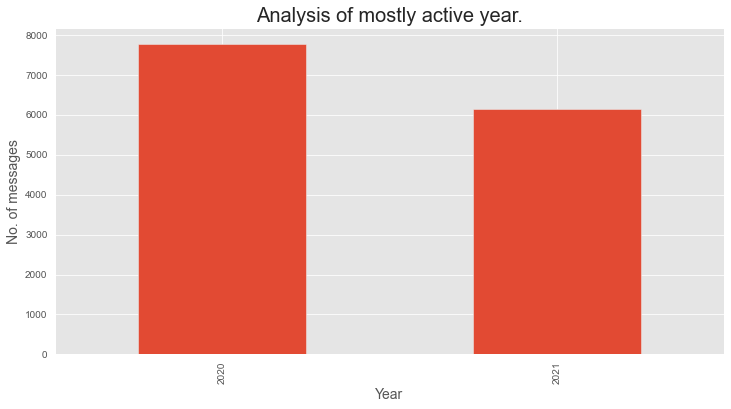

In [211]:
plt.figure(figsize=(12,6))
active_month = df['Year'].value_counts()
a_m = active_month
a_m.plot.bar()
plt.xlabel('Year',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Analysis of mostly active year.',fontdict={'fontsize': 20,'fontweight': 8})
plt.show()


Note that our data contains chats from 9 months of 2020 and only 6 months of 2021. Yet group has reached 80% of total number of messages sent in 9 months of 2020 within 6 months of 2021. This could be because of the fact that as we stay combined in a group for more amount of time, we get many new friends.  

So far, we have analysed the chats and got many interesting and useful results.

---- This Concludes the project------

### Future Work

I wish to do Sentiment Analysis on the messages to find if there is any kind of bullying in the group.